In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir('../../notebook_format')
from formats import load_style
load_style()

In [2]:
os.chdir(path)
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 8, 6 # change default figure size

# magic so that the notebook will reload external python modules
%load_ext autoreload 
%autoreload 2

https://www.tensorflow.org/versions/r0.9/tutorials/word2vec/index.html#vector-representations-of-words

# Distributed Representations of Sentences and Documents

### Introduction into Word2Vec

The last two years, the method and tool developed by Mikolov et al. (2013) for learning continuous word embeddings has gained a lot of traction. The model forms the basis for the study of Le & Mikolov (2014). In order to better understand the methods in that study, I believe it would be good to first present a brief overview of Word2vec. For this overview I gratefully make use of the excellent, in depth explanation of Word2Vec by [Xin Rong (2014)](http://arxiv.org/abs/1411.2738). To have a more complete understanding of the model, please have a look at that paper.

Word2Vec attempts to associate words with points in space. The spatial distance between words then describes the relation (similarity) between these words. Words that are spatially close, are similar. Words are represented by continuous vectors over $x$ dimensions. This example shows the relation between a number of words where each word is represented by a vector of two dimensions:

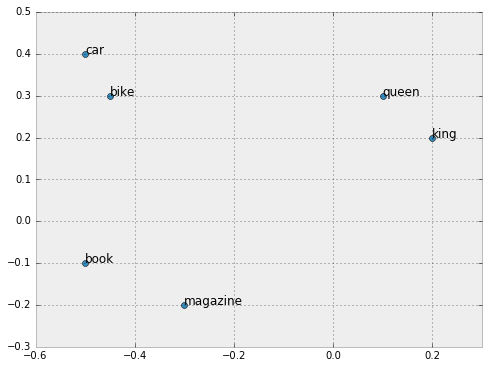

In [3]:
words = ['queen', 'book', 'king', 'magazine', 'car', 'bike']
vectors = np.array([[0.1,   0.3],  # queen
                    [-0.5, -0.1],  # book
                    [0.2,   0.2],  # king
                    [-0.3, -0.2],  # magazine
                    [-0.5,  0.4],  # car
                    [-0.45, 0.3]]) # bike

plt.plot( vectors[:,0], vectors[:,1], 'o' )
plt.xlim(-0.6, 0.3)
plt.ylim(-0.3, 0.5)
for word, x, y in zip( words, vectors[:,0], vectors[:,1] ):
    plt.annotate( word, (x, y), size = 12 )

The displacement vector (the vector between two vectors) describes the relation between two words. This makes it possible to compare displacement vectors to find pairs of words that have a similar relation to each other. A famous example given in the original paper is the following analogy relation: `queen : king :: woman : man` which should be read as `queen` relates to `king` in the same way as `woman` relates to `man`. In algebraic formulation: $v_{queen} - v_{king} = v_{woman} - v_{man}$. This technique of analogical reasoning can be applied to e.g. question answering. 

Word2Vec learns continuous word embeddings from plain text. But how? The model assumes the *Distributional Hypothesis* that words are characterized by words they hang out with. We can use that idea to estimate the probability of two words occurring near each other, e.g. what is the probability of the following words, given *Cinderella*, i.e $P(w|\textrm{Cinderella})$?

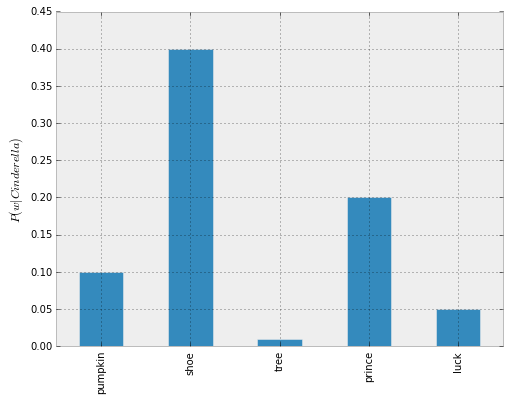

In [4]:
# made up numbers
s = pd.Series( [0.1, 0.4, 0.01, 0.2, 0.05], 
               index = ["pumpkin", "shoe", "tree", "prince", "luck"] )
s.plot(kind = 'bar')
plt.ylabel("$P(w|Cinderella)$")
plt.show()

#### Softmax Regression

Word2Vec is a neural network with a single hidden layer. Have a look at the following picture (taken from [Rong 2014](http://arxiv.org/abs/1411.2738)).

![](neural-network.png)

The neural network contains two matrics: $W$ and $W'$ of dimensions $V \times N$ and $N \times V$ respectively, where $V$ is the vocabulary size and $N$ the size of the hidden layers.

The model considers each word $w_o$ in turn along with a given context $C$ (e.g. $w_O$=*Cinderella* and $C$=*shoe*). Now given this context, can we predict what $w_O$ should be? This is essentially a multiclass classification where we have as many labels as our vocabulary size $V$. Using softmax regression, we can compute a probability distribution $\hat{y}$ over the labels. The model attempts to minimize via Stochastic Gradient Descent the difference between the output distribution and the target distribution (which is a one-hot distribution which places all probability mass on the correct word). The difference between the two distribution is measured by the cross-entropy.

Let's make this all a little more concrete with a small example. Say we have a corpus containing the following documents:

In [5]:
sentences = ['the king loves the queen', 'the queen loves the king',
             'the dwarf hates the king', 'the queen hates the dwarf',
             'the dwarf poisons the king', 'the dwarf poisons the queen']

We first transform these documents into bag-of-indices to enable easier computation:

In [18]:
from collections import defaultdict
# A defaultdict will never raise a KeyError. 
# Any key that does not exist gets the value returned by the default factory.
vocab = defaultdict()
vocab.default_factory = lambda: len(vocab)

def docs2bow( docs, vocab ):
    """
    Transforms a list of strings into a list of lists where 
    each unique item (word) is converted into a unique integer id
    """
    for doc in docs:
        yield [ vocab[word] for word in doc.split() ]

In [24]:
sentences_bow = list( docs2bow( sentences, vocab ) )
print( 'unqiue words:', len(vocab), '\n' )
sentences_bow

unqiue words: 7 



[[0, 1, 2, 0, 3],
 [0, 3, 2, 0, 1],
 [0, 4, 5, 0, 1],
 [0, 3, 5, 0, 4],
 [0, 4, 6, 0, 1],
 [0, 4, 6, 0, 3]]

We now construct the two matrices $W$ and $W'$:

In [26]:
V, N = len(vocab), 3
WI = ( np.random.random(( V, N )) - 0.5 ) / N
WO = ( np.random.random(( N, V )) - 0.5 ) / V

Each row $i$ in $W$ corresponds to word $i$ and each column $j$ corresponds to the $j$th dimension.

In [27]:
print(WI)

[[-0.14043132 -0.05018467 -0.11274577]
 [-0.0814377  -0.07403206 -0.12630872]
 [-0.06771119 -0.00711821  0.05499917]
 [ 0.10153771  0.05181018 -0.00492658]
 [-0.12705191  0.05421463 -0.16658169]
 [-0.04967239 -0.13914268  0.15179769]
 [-0.04093045  0.15265955  0.12302116]]


Notice that $W'$ isn't simply the transpose of $W$ but a different matrix:

In [28]:
print(WO)

[[ 0.01752812 -0.05020307 -0.04398486  0.00665762  0.00054894 -0.0640597
   0.05308743]
 [ 0.06610842  0.05508957 -0.0102559   0.03273979  0.05867376 -0.06085141
   0.04751946]
 [-0.04469135 -0.04587998 -0.06234401  0.03041152  0.00538411 -0.05106182
   0.0521496 ]]


With the two matrices in place we continue with computing the posterior probability of an output word given some input word. Given an input word $w_I$, e.g. *dwarf* and its corresponding vector $W_I$, what is the probability that the output word $w_O$ is *hates*? Using the dot product $W_I \cdot W'^T_O$ we compute the distance between the input word *dwarf* and the output word *hates*:

In [46]:
np.dot( WI[ vocab['dwarf'] ], WO.T[ vocab['hates'] ] )

0.013345834357730693

Now using softmax function, we can compute the posterior probability $P(w_O|w_I)$:

$$ P(w_O|w_I) = y_i = \frac{exp(W_I \cdot W'^T_O)}{\sum^V_{j=1} exp(W_I \cdot W'^T_j)} $$

In [48]:
numerator = np.exp( np.dot( WI[ vocab['dwarf'] ], WO.T[ vocab['hates'] ] ) )
denominator = 0
for w in vocab:
    d = np.exp( np.dot( WI[ vocab['dwarf'] ], WO.T[ vocab[w] ] ) )
    denominator += d

p_hates_dwarf = numerator / denominator
p_hates_dwarf

0.14394812289352618

#### Updating the hidden-to-output layer weights

Word2Vec attempts to associate words with points in space. These points in space are represented by the continuous embeddings of the words. All vectors are initialized as random points in space, so we need to *learn* better positions. The model does so by maximizing the softmax equation above. The corresponding loss function which we try to minimize is $E = -\log P(w_O|w_I)$. First, let's focus on how to update the hidden-to-output layer weights. Say the target output word is *Cinderella*. Given the aformentioned one-hot target distribution $t$, the error can be computed as $t_j - y_j = e_j$, where $t_j$ is 1 if $w_j$ is the actual output word. So, the actual output word is *Cinderella* and we compute the posterior probability of P(*pumpkin* | *tree*), the error will be 0 - P(*pumpkin* | *tree*), because *pumpkin* isn't the actual ouput word. 

To obtain the gradient on the hidden-to-output weights, we compute $e_j \cdot h_i$, where $h_i$ is a copy of the vector corresponding to the input word (only holds with a context of a single word). Finally, using stochastic gradient descent, with a learning rate $\nu$ we obtain the weight update equation for the hidden to output layer weights:

$$W'^{T (t)}_j = W'^{T (t-1)}_j - \nu \cdot e_j \cdot h_j$$

Assume the target word is *king* and the context or input word $C$ is *queen*. Given this input word we compute for each word in the vocabulary the posterior probability P(word | *queen*). If the word is our target word, the error will be 1 - P(word | *queen*); otherwise 0 - P(word | *queen*). Finally, using stocastic gradient descent we update the hidden-to-output layer weights:

In [15]:
target_word = 'king'
input_word = 'queen'
learning_rate = 1.0

for word in vocabulary:
    p_word_queen = (np.exp(np.dot(WO.T[vocabulary[word]], WI[vocabulary[input_word]])) / 
                    sum(np.exp(np.dot(WO.T[vocabulary[w]], WI[vocabulary[input_word]]))
                        for w in vocabulary))
    t = 1 if word == target_word else 0
    error = t - p_word_queen
    WO.T[vocabulary[word]] = (WO.T[vocabulary[word]] - learning_rate * 
                              error * WI[vocabulary[input_word]])
print WO

[[-0.06243581  0.14095147 -0.02669861 -0.04758839 -0.0239239  -0.03947435
   0.02543349]
 [ 0.00263098  0.09964895 -0.02877623  0.06427316 -0.00177368  0.03300138
  -0.00966859]
 [-0.04061539  0.11576201  0.01928528  0.03143168  0.02402065 -0.02701589
  -0.02603086]]


#### Updating the input-to-hidden layer weights

Now that we have a way to update the hidden-to-output layer weights, we concentrate on updating the input-to-hidden layer weights. We need to backpropagate the prediction errors to the input-to-hidden weights. We first compute $EH$ which is an $N$ dimensional vector representing the sum of the hidden-to-output vectors for each word in the vocabulary weighted by their prediction error:

$$\sum^V_{j=1} e_j \cdot W'_{i,j} = {EH}_i$$

Again using the learning rate $\nu$ we update the weights using:

$$W^{(t)}_{w_I} = W^{(t-1)}_{w_I} - \nu \cdot EH$$

Let's see how that works in Python:

In [16]:
WI[vocabulary[input_word]] = WI[vocabulary[input_word]] - learning_rate * WO.sum(1)

If we now would recompute the probability of each word given the input word *queen*, we see that the probability of *king* given *queen* has gone up:

In [17]:
for word in vocabulary:
    p = (np.exp(np.dot(WO.T[vocabulary[word]], WI[vocabulary[input_word]])) / 
         sum(np.exp(np.dot(WO.T[vocabulary[w]], WI[vocabulary[input_word]])) 
             for w in vocabulary))
    print word, p

king 0.135793930736
dwarf 0.143640274055
queen 0.141911808054
poisons 0.144219025126
loves 0.14461048255
the 0.1457335424
hates 0.144090937079


#### Multi-word context

![](neural-network-cbow.png)

*Figure taken from (Rong 2014)*

The model described above is the CBOW architecture of Word2Vec. However, we assumed that the context $C$ was only a single input word. This allowed us to simply copy the input vector to the hidden layer. If the context $C$ comprises multiple words, instead of copying the input vector we take the mean of their input vectors as our hidden layer:

$$h = \frac{1}{C} (W_1 + W_2 + \ldots + W_C)$$

The update functions remain the same except that for the update of the input vectors, we need to apply the update to each word in the contect $C$:

$$W^{(t)}_{w_I} = W^{(t-1)}_{w_I} - \frac{1}{C} \cdot \nu \cdot EH$$

Let's see that in action. Again assume the target word is *king*. The context consists of two words: *queen* and *loves*.

In [18]:
target_word = 'king'
context = ['queen', 'loves']

We first take the average of the two context vectors:

In [19]:
h = (WI[vocabulary['queen']] + WI[vocabulary['loves']]) / 2

Then we apply the hidden-to-output layer update:

In [20]:
for word in vocabulary:
    p_word_context = (np.exp(np.dot(WO.T[vocabulary[word]], h)) / 
                            sum(np.exp(np.dot(WO.T[vocabulary[w]], h)) for w in vocabulary))
    t = 1 if word == target_word else 0
    error = t - p_word_context
    WO.T[vocabulary[word]] = WO.T[vocabulary[word]] - learning_rate * error * h
print WO

[[-0.08162148  0.25512914 -0.04589425 -0.06655692 -0.04307783 -0.05847402
   0.0063956 ]
 [-0.02294998  0.25188627 -0.0543705   0.03898171 -0.02731232  0.00766842
  -0.03505252]
 [-0.04383296  0.13491036  0.01606604  0.02825053  0.02080841 -0.03020226
  -0.02922364]]


Finally we update the vector of each input word in the context:

In [21]:
for input_word in context:
    WI[vocabulary[input_word]] = (WI[vocabulary[input_word]] - (1. / len(context)) * 
                                  learning_rate * WO.sum(1))

In [22]:
h = (WI[vocabulary['queen']] + WI[vocabulary['loves']]) / 2
for word in vocabulary:
    p = (np.exp(np.dot(WO.T[vocabulary[word]], h)) / 
               sum(np.exp(np.dot(WO.T[vocabulary[w]], h)) for w in vocabulary))
    print word, p

king 0.129518690596
dwarf 0.145150475243
queen 0.143019721408
poisons 0.145122173218
loves 0.146255939585
the 0.146300899102
hates 0.144632100847


### Paragraph Vector

Hopefully we know have a better understanding of how Word2Vec learns continuous word embeddings from texts. Note that in order to efficiently apply this algorithm to real texts, we need some more tricks which I won't cover here. For now I would like to proceed with the Paragraph Vector described in Le & Mikolov (2014). 

The Paragraph Vector model attempts to learn fixed-length continuous representations from variable-length pieces of text. These representations combine bag-of-words features with word semantics and can be used in all kinds of NLP applications.

If you read the paper, I think it will be clear by now that the Paragraph Vector is only a very small extension of the original model. Similar to the Word2Vec model, the Paragraph Vector model also attemts to predict the next word in a sentence. The only real difference, as the paper itself states, is with the computation of $h$. Where in the original model $h$ is based solely on $W$, in the new model we add another matrix called $D$, representing the vectors of paragraphs:

![](doc2vec.png)

A paragraph token can be thought of as yet another word token except that (at least in the paper) all paragraph vectors are unique, whereas word tokens share their vector representations among different contexts. At each step we compute $h$ by concatenating or averaging a paragraph vector $d$ with a context of word vectors $C$:

$$ h = \frac{1}{C} \cdot (D_d + W_1 + W_W + \ldots + W_C)$$

The weight update functions are the same as in Word2Vec except that we now also update the paragraph vectors. This first model is called the Distributed Memory Model of Paragraph Vectors. Le & Mikolov present another model called Distributed Bag of Words Model of Paragraph Vector. This model ignores the context $C$ and attempts to predict a randomly sampled word from a randomly sampled context window. 

Let's have a more detailed look at the DM Model. In addition to the matrix $W$ we need to randomly initialize a matric $D$ with dimensions $P \times N$ where $P$ is the number of paragraphs or whatever textual unit we use, and $N$ is the number of dimensions.

In [27]:
V, N, P = len(vocabulary), 3, 5
WI = (np.random.random((V, N)) - 0.5) / N
WO = (np.random.random((N, V)) - 0.5) / V
D =  (np.random.random((P, N)) - 0.5) / N

Say out corpus consists of the following five sentences (paragraphs):

In [28]:
sentences = ['snowboarding is dangerous', 'skydiving is dangerous',
             'escargots are tasty to some people', 'everyone loves tasty food',
             'the minister has some dangerous ideas']

We first convert the sentences into a vectorial BOW representation:

In [29]:
vocabulary = Vocabulary()
sentences_bow = list(docs2bow(sentences, vocabulary))
sentences_bow

[[0, 1, 2],
 [3, 1, 2],
 [4, 5, 6, 7, 8, 9],
 [10, 11, 6, 12],
 [13, 14, 15, 8, 2, 16]]

Next we compute the posterior probability for each word in the vocabulary given the concatenation and averaging of the first paragraph and the context word *snowboarding*. We compute the error and update the hidden-to-output layer weights.

In [30]:
target_word = 'dangerous'
h = (D[0] + WI[vocabulary['snowboarding']]) / 2
learning_rate = 1.0

for word in vocabulary:
    p = (np.exp(np.dot(WO.T[vocabulary[word]], h)) / 
                      sum(np.exp(np.dot(WO.T[vocabulary[w]], h)) for w in vocabulary))
    t = 1 if word == target_word else 0
    error = t - p
    WO.T[vocabulary[word]] = (WO.T[vocabulary[word]] - learning_rate * error * h)
print WO

[[-0.01599941  0.02135301  0.0927715  -0.00565041 -0.00361651 -0.01454073
   0.02333261  0.00211833  0.00254255  0.02315315 -0.01917578  0.00724787
  -0.00117272 -0.02043504  0.00593186 -0.0166333  -0.0306218 ]
 [ 0.0089237  -0.00397806 -0.13199195  0.02555059 -0.02095756 -0.00978333
   0.01561624  0.03603476 -0.02114407 -0.01552016  0.01289922  0.00119743
  -0.00112818  0.01708133  0.00765248  0.02442374  0.01109005]
 [-0.01205008 -0.03123478  0.05878695  0.02615259 -0.01025209 -0.00442044
   0.00311309  0.01554668  0.02344194  0.00602561 -0.03117694  0.01368817
   0.00858936 -0.00223242 -0.01141366 -0.01719967 -0.01400046]]


We backpropagate the error to the input-to-hidden layer as follows:

In [31]:
EH = WO.sum(1)
WI[vocabulary['snowboarding']] = WI[vocabulary['snowboarding']] - 0.5 * learning_rate * EH
D[0] = D[0] - 0.5 * learning_rate * EH

### Experiments

Le & Mikolov evaluate and investigate the performance of the paragraph vectors on a number of different tasks. I will briefly discuss them here.

#### Sentiment Analysis

In the first experiment, the authors address the task of sentiment analysis. They make use of the Stanford Sentiment Treebank Dataset which is a manually annotated data set containing 11855 sentences taken from the movie review site Rotten Tomatoes. Each sentence in the data set has been assigned a label on a scale of negative to positive. The task is to predict these labels. 

Le & Mikolov train Paragraph Vectors using both the DM Model and the DBOW model. These two representations are concatenated for each training instance and fed to a Logistic Regression classifier that makes a prediction for each unseen test sentence. They compare the performance of the model to a number of different models:

![](results-1.png)

Le & Mikolov then move on beyond the sentence level and evaluate their model on the IMDB data set. Training and testings follows the same procedure as before. The results presented below suggest a strong improvement compared to the other reported models:

![](results-2.png)

#### Information Retrieval

The authors then turn to an experiment in Information Retrieval. They develop a task in which the goal is to predict which of three paragraphs isn't the result of the same query. They construct a data set on the basis of the search results of a search engine. For each query they create a triplet of paragraphs: two paragraphs are results from the same query and one is randomly sampled from the rest of the collection (result from a different query). The pairwise distances between each member of a triplet, should then reflect which two results belong to the same query and which snippet is the outlier. The following table shows quite convincingly how well the paragraph vectors are able to perform on this task compared to the other methods:

![](results-3.png)

### Comments / Points of critique

#### General remarks

Although the proposed model is only a small step beyond the original word2vec model (and some of the writings is quite sloppy), I think it is a really clever one with much potential for many different applications. The ease with which the model can be applied to text pieces of variable length is perhaps the strongest advantage of the model. 

#### Availability of code / experimentation details

No implementation was available (even not to the second author, which led to some serious doubts about the reproducability of the results:

![](response-mikolov.png)

After a nice series of discussion, the first author finally made a suggestion on how to improve the results and actually come to the same performance as reported in the paper:

![](quoc-response.png)

It is applaudable for the authors to interact and respond to comments by the readers. On the other hand, if they would have developed an implementation similar to the original word2vec, this discussion (and the resulting doubts in the method) wouldn't have to take place. The authors report a number of hyperparameters in the paper, such as the window size and the number of dimensions of the vectors. However, some crucial parameters weren't mentioned (such as the use of hierarchical softmax verus negative sampling). Again, in order to reproduce the results, the authors must specify in much greater detail how they performed the experiments.